# Find the Planet Basemaps Quad ID's for a Region 

This notebook is used for idetifying the Planet Basemap quads that intersec a region of interest. In this notebook, we:

1. Authenticate with our Planet credentials
1. Query the basemap API for available imagery
1. Load in boundary data for our tgo_adm0 of interest
1. Define the geometry for our area of interest (AOI)
1. Get the Quad IDs to and geometry
1. Save the ID, country, and geometry for the quads we want

Code inspiration taken from [Lesson2a_get_planet_NICFI](https://developmentseed.org/tensorflow-eo-training/docs/Lesson2a_get_planet_NICFI.html)

## Setup

In [2]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm

sys.path.append("./utils")

# import config
import data_utils
import nicfi_key
import planet_utils


geodetic = "EPSG:4326"
mercator = "EPSG:3857"
mollweide = "ESRI:54009"


## Authenticate and Select Basemap Mosaic

Planet basemaps and NICFI basemaps all share the same unified grid. In this section, we query for available basemaps and choose one. 

In theory, any basemap should be okay to use. In practice, some basemaps are not complete. If you were to select the first basemap in the list, there would be many gaps. We choose a product that I have tested (see plot at bottom), and that is the basemap we are interested in for our work. 

In [3]:
PLANET_API_KEY = nicfi_key.nicfi_key
planet = planet_utils.PlanetAPI(PLANET_API_KEY, planet_utils.basemap_url)
mosaic_names = planet.get_mosaics()
mosaic_names = [name for name in mosaic_names if "normalized" in name]
mosaic_names

['planet_medres_normalized_analytic_2015-12_2016-05_mosaic',
 'planet_medres_normalized_analytic_2016-06_2016-11_mosaic',
 'planet_medres_normalized_analytic_2016-12_2017-05_mosaic',
 'planet_medres_normalized_analytic_2017-06_2017-11_mosaic',
 'planet_medres_normalized_analytic_2017-12_2018-05_mosaic',
 'planet_medres_normalized_analytic_2018-06_2018-11_mosaic',
 'planet_medres_normalized_analytic_2018-12_2019-05_mosaic',
 'planet_medres_normalized_analytic_2019-06_2019-11_mosaic',
 'planet_medres_normalized_analytic_2019-12_2020-05_mosaic',
 'planet_medres_normalized_analytic_2020-06_2020-08_mosaic',
 'planet_medres_normalized_analytic_2020-09_mosaic',
 'planet_medres_normalized_analytic_2020-10_mosaic',
 'planet_medres_normalized_analytic_2020-11_mosaic',
 'planet_medres_normalized_analytic_2020-12_mosaic',
 'planet_medres_normalized_analytic_2021-01_mosaic',
 'planet_medres_normalized_analytic_2021-02_mosaic',
 'planet_medres_normalized_analytic_2021-03_mosaic',
 'planet_medres_nor

In [4]:
mosaic_names = ["planet_medres_normalized_analytic_2024-12_mosaic"]

## Load Country Boundaries 

Here we define the set of tgo_adm0 we are interested in. This geo-dataframe contains the polygon information for each country. 

In [5]:
country_code = "TGO"
level = "ADM0"

adm_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"

tgo_adm0_fp = (
    f"{adm_url}/{country_code}/{level}/geoBoundaries-{country_code}-{level}.geojson"
)

tgo_adm0 = gpd.read_file(tgo_adm0_fp)

tgo_adm0["country"] = tgo_adm0.shapeISO

tgo_adm0 = tgo_adm0[["country", "geometry"]]

tgo_adm0

,country,geometry
0,TGO,"POLYGON ((-0.12366 11.137, -0.1309 11.13846, -..."


## Get Quad IDs

In this section we use a custom function `get_items()` to identify the unique quad ID's that intersect our tgo_adm0. This function returns the entire item metadata, which we vonvert into a geo-dataframe with `convert_items_to_geodataframe()`. We append these to a list of geo-dataframes that we concatenate and filter later.

One problem with querying Planet, that the verticies of a polygon are limited to just 500 points. This means we need to simplify complex geometries. We can do this by using the `total_bouds` attribute of our geo-dataframe. Alternatively we can do this by using the convex hull. 

In [6]:
tgo_grid = data_utils.create_grid(
    tgo_adm0,
    resolution=0.01,
    geometry_col="geometry",
    id_col="shapeISO",
    return_ids=True,
)
tgo_grid_gdf = gpd.GeoDataFrame(
    tgo_grid,
    geometry=gpd.points_from_xy(tgo_grid.lon, tgo_grid.lat),
    crs="EPSG:4326",
)
tgo_grid_gdf.geometry = tgo_grid_gdf.geometry.buffer(0.005, cap_style=3)

print(f"Shape (row, col): {tgo_grid_gdf.shape}")

tgo_grid_gdf.head()

Shape (row, col): (46599, 5)


/var/folders/sn/h82qf8ws0016_fgmpp88gfhc0000gn/T/ipykernel_53278/3053577114.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tgo_grid_gdf.geometry = tgo_grid_gdf.geometry.buffer(0.005, cap_style=3)


,lat,lon,shapeISO,unique_id,geometry
0,11.135,-0.125,feature_0,lon_-0.125__lat_11.135,"POLYGON ((-0.12 11.14, -0.12 11.13, -0.13 11.1..."
1,11.135,-0.115,feature_0,lon_-0.115__lat_11.135,"POLYGON ((-0.11 11.14, -0.11 11.13, -0.12 11.1..."
2,11.125,-0.135,feature_0,lon_-0.135__lat_11.125,"POLYGON ((-0.13 11.13, -0.13 11.12, -0.14 11.1..."
3,11.125,-0.125,feature_0,lon_-0.125__lat_11.125,"POLYGON ((-0.12 11.13, -0.12 11.12, -0.13 11.1..."
4,11.125,-0.115,feature_0,lon_-0.115__lat_11.125,"POLYGON ((-0.11 11.13, -0.11 11.12, -0.12 11.1..."


In [7]:
basemap_dir = "basemaps"

for mosaic in tqdm(mosaic_names, desc="Mosaics"):
    planet.set_mosaic(mosaic)
    bbox_aoi = tgo_adm0.geometry.total_bounds
    all_items = planet.get_items(bbox_aoi)
    quad_df = planet.convert_items_to_geodataframe(all_items)
    quad_df = quad_df.drop_duplicates(subset="id")

    quad_df = quad_df.sjoin(tgo_adm0, predicate="intersects")
    quad_df.drop(columns=["index_right"], inplace=True)

    intersecting = gpd.sjoin(
        tgo_grid_gdf.reset_index(),
        quad_df,
        how="left",
        predicate="intersects",
    )
    tgo_grid_gdf["quad_id"] = intersecting.groupby("index")["id"].apply(list).values

    tgo_grid_gdf = tgo_grid_gdf[
        ~tgo_grid_gdf["quad_id"].apply(data_utils.contains_nan)
    ]

    tgo_grid_gdf = tgo_grid_gdf.to_crs(mercator)

    file_dir = os.path.join(basemap_dir, mosaic, "quad_ids")
    os.makedirs(file_dir, exist_ok=True)

    quad_fn = os.path.join(file_dir, "quad_ids.geojson")
    quad_df.to_file(quad_fn, driver="GeoJSON")

    grid_fn = os.path.join(file_dir, "tgo_grid_gdf.parquet")
    tgo_grid_gdf.to_parquet(grid_fn)

Mosaics: 100%|██████████| 1/1 [02:01<00:00, 121.39s/it]


In [9]:
tgo_grid_gdf

,lat,lon,shapeISO,unique_id,geometry,quad_id
0,11.135,-0.125,feature_0,lon_-0.125__lat_11.135,"POLYGON ((-13358.339 1247987.013, -13358.339 1...",[1023-1087]
1,11.135,-0.115,feature_0,lon_-0.115__lat_11.135,"POLYGON ((-12245.144 1247987.013, -12245.144 1...",[1023-1087]
2,11.125,-0.135,feature_0,lon_-0.135__lat_11.125,"POLYGON ((-14471.534 1246852.46, -14471.534 12...",[1023-1087]
3,11.125,-0.125,feature_0,lon_-0.125__lat_11.125,"POLYGON ((-13358.339 1246852.46, -13358.339 12...",[1023-1087]
4,11.125,-0.115,feature_0,lon_-0.115__lat_11.125,"POLYGON ((-12245.144 1246852.46, -12245.144 12...",[1023-1087]
...,...,...,...,...,...,...
46594,6.125,1.205,feature_0,lon_1.205__lat_6.125,"POLYGON ((134696.584 683694.052, 134696.584 68...",[1030-1058]
46595,6.125,1.215,feature_0,lon_1.215__lat_6.125,"POLYGON ((135809.779 683694.052, 135809.779 68...",[1030-1058]
46596,6.125,1.225,feature_0,lon_1.225__lat_6.125,"POLYGON ((136922.974 683694.052, 136922.974 68...",[1030-1058]
46597,6.125,1.235,feature_0,lon_1.235__lat_6.125,"POLYGON ((138036.169 683694.052, 138036.169 68...","[1030-1058, 1031-1058]"


## Download Basemaps

In [10]:
for mosaic in sorted(mosaic_names, reverse=True):
    print(f"Processing {mosaic}...", end="\n")
    mosaic_dir = basemap_dir + "/" + mosaic
    quad_dir = mosaic_dir + "/basemap_quads"
    quad_id_fp = mosaic_dir + "/quad_ids/quad_ids.geojson"

    quad_df = gpd.read_file(quad_id_fp, driver="GeoJSON")

    quad_ids_list = quad_df.id.tolist()

    os.makedirs(quad_dir, exist_ok=True)
    existing_files = os.listdir(quad_dir)

    filtered_quad_ids_list = planet_utils.filter_existing_quad_ids(
        quad_ids_list, existing_files
    )
    chunked_quad_id_list = planet_utils.chunk_list(filtered_quad_ids_list, 100)

    print(f"N Quads: {len(quad_ids_list)}")
    print(f"N Quads Remaining: {len(filtered_quad_ids_list)}")
    print(f"N Chunks: {len(chunked_quad_id_list)}")

    for i in range(len(chunked_quad_id_list)):
        print(f"Chunk: {i + 1}/{len(chunked_quad_id_list)}", end="\n")

        order_params = {
            "name": "Basemap order with geometry",
            "source_type": "basemaps",
            "order_type": "partial",
            "products": [
                {
                    "mosaic_name": mosaic,
                    "quad_ids": chunked_quad_id_list[i],
                }
            ],
        }

        order = planet.place_order(order_params)

        print("Polling for order success...", end="\n")

        planet.poll_for_success(order, loop_time=10, num_loops=240)

        results = planet.get_results(order)

        planet.download_results(
            results,
            directory=basemap_dir,
            overwrite=False,
            show_progress=True,
            max_retries=5,
        )

        print("Organizing files...", end="\n")

        planet.organize_files(
            base_dir=basemap_dir,
            mosaic_name=mosaic,
            overwrite=False,
            verbose=False,
        )

        print("Done!", end="\n\n")

Processing planet_medres_normalized_analytic_2024-12_mosaic...
N Quads: 205
N Quads Remaining: 0
N Chunks: 0


/Users/cullenmolitor/miniconda3/envs/mosaiks/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


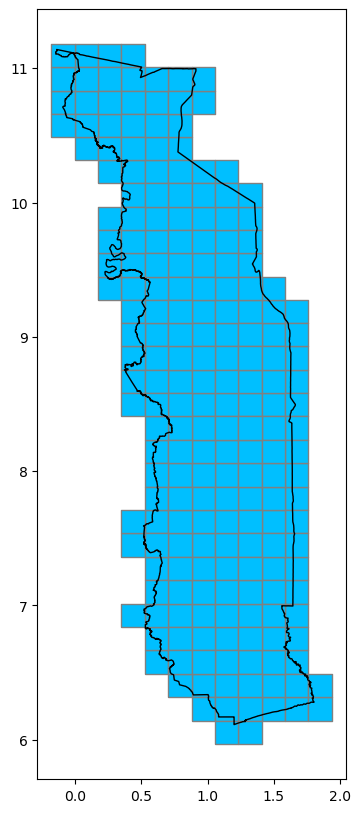

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

quad_df.plot(ax=ax, edgecolor="grey", color="deepskyblue")
tgo_adm0.plot(ax=ax, color="None", edgecolor="black")

plt.show()

## Check for successful downloads

In [12]:
basemap_list = os.listdir(basemap_dir)

basemap_list = [mosaic for mosaic in basemap_list if "DS_Store" not in mosaic]

basemap_list

['planet_medres_normalized_analytic_2024-12_mosaic']

In [13]:
basemap_list = os.listdir(basemap_dir)

basemap_list = [mosaic for mosaic in basemap_list if "DS_Store" not in mosaic]

paths = []
for mosaic in basemap_list:
    directory = os.path.join(basemap_dir, mosaic, "basemap_quads")
    small_files, small_paths = data_utils.list_small_files(directory)
    paths.extend(small_paths)
paths

Processing files: 100%|██████████| 205/205 [00:00<00:00, 58908.76file/s]


[]

### Remove any unsuccessful downloads

In [14]:
for file in paths:
    os.remove(file)
    print(f"Deleted: {file}")

In [23]:
import os
import logging
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
import geopandas as gpd
from tqdm.notebook import tqdm

# Setup logging
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

# Get quad file paths
def get_quad_paths(quad_ids, quad_dir):
    return [os.path.join(quad_dir, f"{qid}_quad.tif") for qid in quad_ids]

# Merge and clip quads
def merge_and_clip(quad_paths, geometry):
    with rasterio.Env():
        # Open all quad files using context managers
        with rasterio.open(quad_paths[0]) as src0:
            meta = src0.meta.copy()
            if len(quad_paths) > 1:
                with rasterio.open(quad_paths[1]) as src1:
                    merged, out_transform = merge([src0, src1])
            else:
                merged = src0.read()
                out_transform = src0.transform

        # Update metadata for the merged image
        meta.update({
            "driver": "GTiff",
            "height": merged.shape[1],
            "width": merged.shape[2],
            "transform": out_transform,
            "compress": "lzw",
        })

        # Write merged image to a memory file and apply clipping
        with rasterio.io.MemoryFile() as memfile:
            with memfile.open(**meta) as dataset:
                dataset.write(merged)
                clipped, clipped_transform = mask(dataset, [geometry], crop=True, all_touched=True)

        if clipped.shape[0] > 4:
            clipped = clipped[:4]

        # Update metadata for the clipped image
        meta.update({
            "height": clipped.shape[1],
            "width": clipped.shape[2],
            "transform": clipped_transform,
            "count": clipped.shape[0],
            "compress": "lzw",
        })

    return clipped, meta

# Save the clipped image
def save_clipped_image(clipped, meta, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, "w", **meta) as dest:
        dest.write(clipped)
    # logging.info(f"Saved clipped image to: {output_path}")

# Process a single task
def process_task(row, basemap_quads_dir, clipped_images_dir, overwrite=False):
    basemap_name = "planet_medres_normalized_analytic_2024-12_mosaic"
    unique_id = row["unique_id"]
    quad_ids = row["quad_id"]
    geometry = row["geometry"]
    output_path = os.path.join(clipped_images_dir, f"{unique_id}.tif")

    if os.path.exists(output_path) and not overwrite:
        # logging.info(f"Skipped existing file: {unique_id} for {basemap_name}")
        return False

    quad_paths = [p for p in get_quad_paths(quad_ids, basemap_quads_dir) if os.path.exists(p)]
    if not quad_paths:
        logging.warning(f"No quad paths found for {unique_id} in {basemap_name}")
        return False

    try:
        clipped, meta = merge_and_clip(quad_paths, geometry)

        if clipped.shape[1] >= 10 and clipped.shape[2] >= 10:
            save_clipped_image(clipped, meta, output_path)
            return True
        else:
            logging.info(
                f"Skipped saving {unique_id} for {basemap_name} due to small size "
                f"({clipped.shape[2]}x{clipped.shape[1]} pixels)"
            )
            return False
    except Exception as e:
        logging.error(f"Error processing {unique_id} in {basemap_name}: {e}")
        return False

# Main processing function
def main():
    setup_logging()

    base_dir = "/Users/cullenmolitor/Documents/github/MOSAIKS-Training-Manual/notebooks/demo/basemaps"
    mosaic_name = "planet_medres_normalized_analytic_2024-12_mosaic"
    basemap_quads_dir = os.path.join(base_dir, mosaic_name, "basemap_quads")
    clipped_images_dir = os.path.join(base_dir, mosaic_name, "clipped_images")

    total_tasks = len(tgo_grid_gdf)
    logging.info(f"Total tasks to process: {total_tasks}")

    processed_count = 0
    skipped_count = 0

    for _, row in tqdm(tgo_grid_gdf.iterrows(), total=total_tasks, desc="Processing Images"):
        if process_task(row, basemap_quads_dir, clipped_images_dir, overwrite=False):
            processed_count += 1
        else:
            skipped_count += 1

    logging.info("Processing completed.")
    logging.info(f"Total images processed: {processed_count}")
    logging.info(f"Total images skipped: {skipped_count}")

# Execute the main function
if __name__ == "__main__":
    main()


2025-01-09 15:28:00 - INFO - Total tasks to process: 46599


Processing Images:   0%|          | 0/46599 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# basemap_list = os.listdir(config.clipped_images_dir)

# shapes = []
# # for basemap in tqdm(basemap_list, desc="Processing files", unit="file"):
# for basemap in basemap_list:
#     directory = os.path.join(config.clipped_images_dir, basemap)
#     tif_files = glob.glob(os.path.join(directory, "*.tif"))
#     for tif_file in tqdm(tif_files, desc=basemap, unit="file"):
#         # for tif_file in tif_files:
#         with Image.open(tif_file) as img:
#             width, height = img.size

#         filename = os.path.splitext(os.path.basename(tif_file))[0]
#         shapes.append(
#             {"basemap": basemap, "filename": filename, "h": height, "w": width}
#         )

# # Create a DataFrame from the collected data
# df = pd.DataFrame(shapes)
# df